# Creating Weekly Seasonal Index to Assess Baseline Accuracy
### This report calculates a weekly seasonal index by dividing actuals by baseline values, allowing us to evaluate how closely the baseline forecast matches real data on a week-by-week basis. This index provides insight into seasonal patterns and highlights deviations from the baseline, which can inform future adjustments.


Load Data
Load actual and baseline data from Excel for the year 2024

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'seasonal.xlsx'
actuals_df = pd.read_excel(file_path, sheet_name='Actual_2024')
baseline_df = pd.read_excel(file_path, sheet_name='Base_2024')


Clean and Prepare Actuals Data


In [2]:
actuals_df = actuals_df.loc[:, ~(actuals_df.isnull().all() | (actuals_df == 0).all())]
actuals_df.set_index('Department', inplace=True)
actuals_df.columns = pd.to_datetime(actuals_df.columns, errors='coerce')

Remove Outliers

In [3]:
def remove_outliers(df):
    """Removes outliers using the IQR method for each column (department) in the DataFrame."""
    df = df.T 
    cleaned_df = pd.DataFrame()
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        filtered_col = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound))
        cleaned_df[col] = filtered_col
    return cleaned_df.T

actuals_df = remove_outliers(actuals_df)

Calculate Weekly Totals for Actuals and adding Rolling Weekly Average

In [4]:
actuals_df = actuals_df.T
weekly_actuals = actuals_df.resample('W').sum()
rolling_weekly_avg = actuals_df.rolling(window=7, min_periods=1).mean()

Prepare Daily Baseline Data

In [5]:
baseline_values_df = baseline_df.set_index('Department')
baseline_daily = pd.DataFrame(index=actuals_df.index)
for department in baseline_values_df.index:
    baseline_daily[department] = [baseline_values_df.loc[department, 'Base']] * len(baseline_daily)

Calculate Weekly Baseline Totals

In [6]:
weekly_baseline = pd.DataFrame(index=weekly_actuals.index)
for week_start in weekly_baseline.index:
    week_end = week_start + pd.DateOffset(weeks=1)
    actual_days_count = actuals_df[week_start:week_end].count()
    for department in baseline_values_df.index:
        baseline_daily_value = baseline_values_df.loc[department, 'Base']
        weekly_baseline.loc[week_start, department] = baseline_daily_value * actual_days_count[department]

Calculate Weekly Seasonal Index

In [7]:
seasonal_index_df = weekly_actuals.divide(weekly_baseline, axis=1)

Prepare Data for Visualization

In [8]:
output_df = pd.DataFrame()
for week_number in range(len(weekly_actuals)):
    if week_number < len(weekly_baseline) and week_number < len(seasonal_index_df):
        week_actuals = weekly_actuals.iloc[week_number].rename(f'week_{week_number + 1}_actuals')
        week_baseline = weekly_baseline.iloc[week_number].rename(f'week_{week_number + 1}_base')
        week_seasonal_index = seasonal_index_df.iloc[week_number].rename(f'week_{week_number + 1}_seasonal_index')
        output_df = pd.concat([output_df, week_actuals, week_baseline, week_seasonal_index], axis=1)

output_df.index = baseline_values_df.index

Reshape Data for Plotting & Plot Seasonal Index

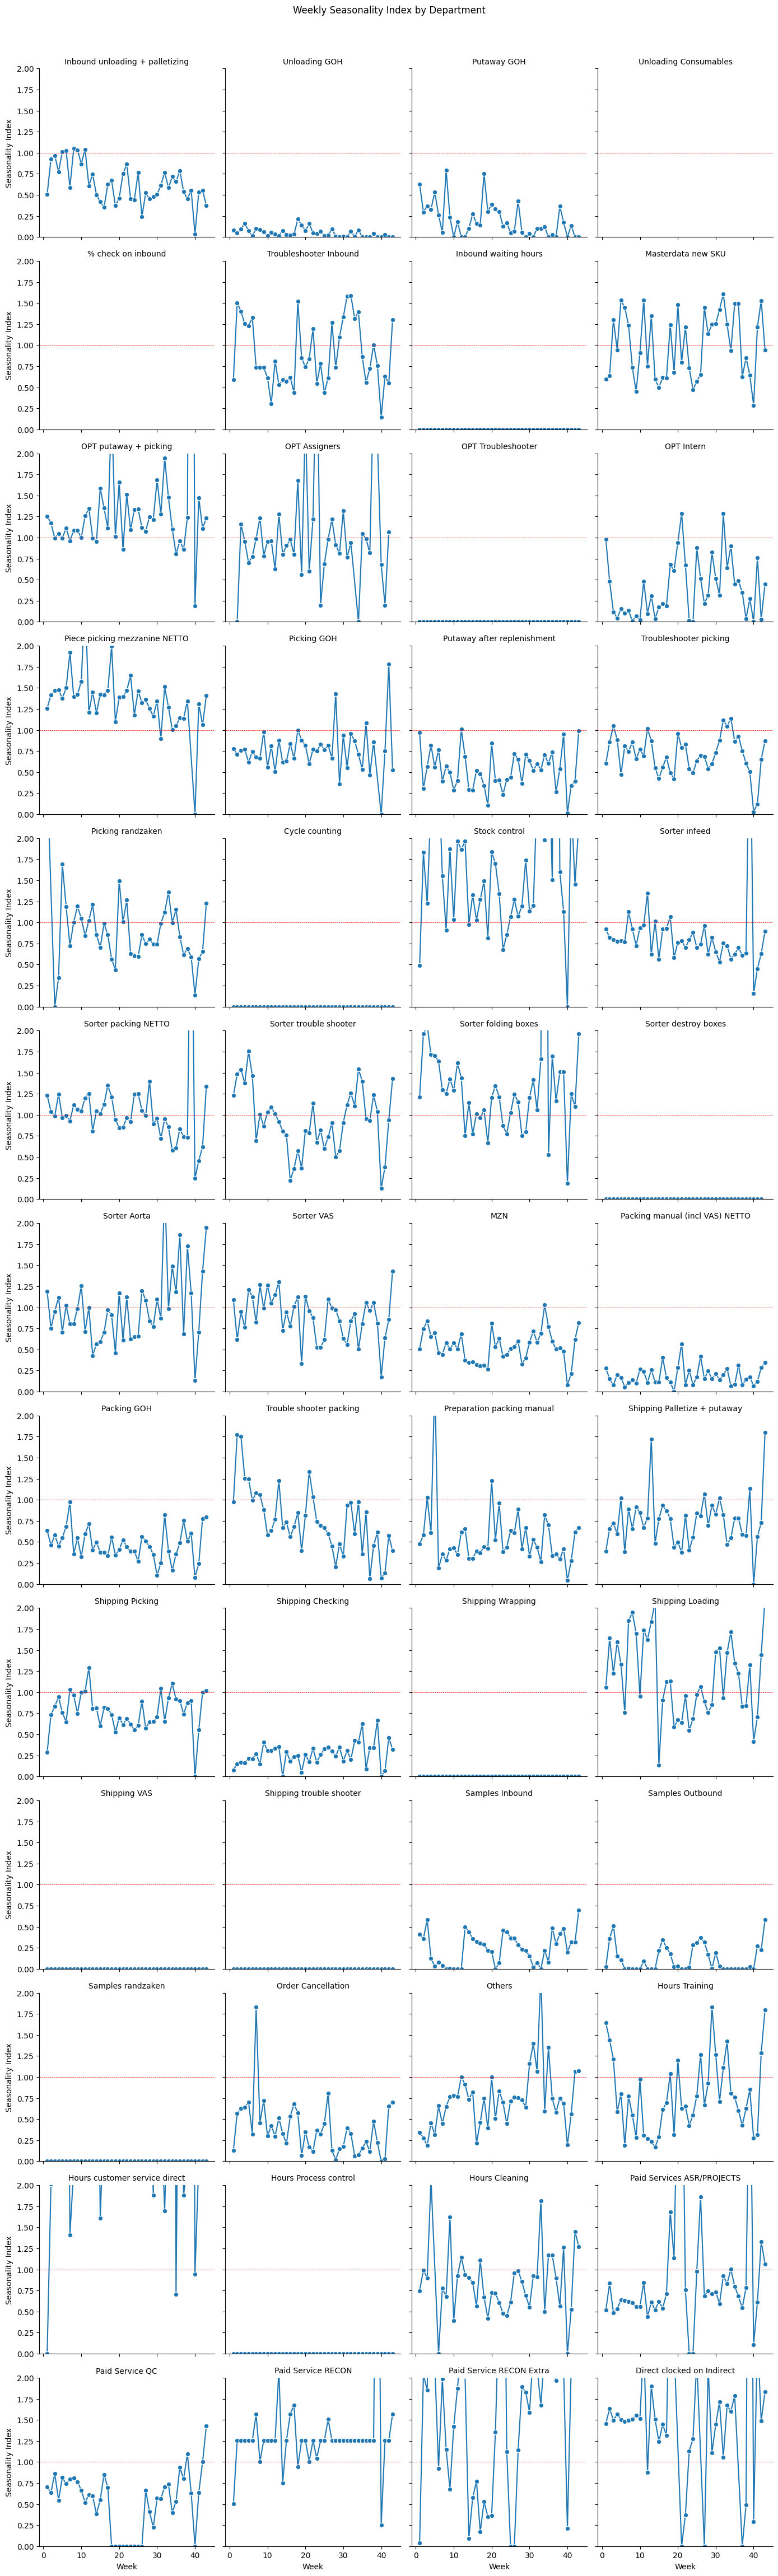

In [11]:
output_long_df = output_df.reset_index().melt(id_vars='Department', var_name='week', value_name='value')
output_long_df['week_number'] = output_long_df['week'].str.extract(r'(\d+)').astype(int)
output_long_df['metric'] = output_long_df['week'].str.extract(r'_(actuals|base|seasonal_index)$')[0]
seasonal_index_df = output_long_df[output_long_df['metric'] == 'seasonal_index']
g = sns.FacetGrid(seasonal_index_df, col='Department', col_wrap=4, height=3.5, aspect=1, sharey=True)
g.map_dataframe(sns.lineplot, x='week_number', y='value', marker='o')
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.axhline(y=1, color='red', linestyle='--', linewidth=0.5)
g.set_titles('{col_name}')
g.set_axis_labels('Week', 'Seasonality Index')
g.fig.suptitle('Weekly Seasonality Index by Department', y=1.01)
plt.tight_layout()
plt.show()

# Conclusion
This analysis highlights the alignment (or misalignment) between our baseline predictions and actual weekly performance using the calculated seasonal index. 
Values below 1 suggest that the baseline forecast overestimated demand, while values above 1 indicate an underestimation. 
These insights reveal areas where the baseline may require adjustments to more accurately reflect actual seasonal patterns.
